Notes and codes for Jackson et al. (2016b) ApJ.

Because I can't think of a better place to put it, I will note here that the radial distance to the Roche lobe along the line connecting the planet and star centers is 3/2 the distance to the Roche lobe at a right angle to that line. In other words, when the planet just fills its Roche lobe, the potential contour that corresponds to the transit radius is 2/3 the distance to the L1 Lagrange point between the planet and star. That's why there is a mysterious factor of 3/2 (or 2/3) that appears in several places below. 

See Li+ (2010 -- http://adsabs.harvard.edu/abs/2010Natur.463.1054L) for additional discussion of this subtle point.

In [1]:
%matplotlib inline
#Calculating mass loss rates for confirmed and candidate planets

from astropy.units import cds
#Now to calculate mass loss rates
from astropy import constants as const
import astropy.units.astrophys as u

import matplotlib.pyplot as plt
from scipy.integrate import dblquad

import itertools as it

import scipy.optimize as so
import numpy as np

#Using Foreman-Mackey's excellent kplr package (http://dan.iel.fm/kplr/) 
#  to interface with the MAST Archive (http://archive.stsci.edu/vo/mast_services.html)
import kplr
client = kplr.API()

import itertools as it

import plotly.plotly as py
import plotly.graph_objs as go

from RLO_funcs import *

#According to Rogers (2015 -- http://iopscience.iop.org/0004-637X/801/1/41/), 
#  planets with radii bigger than this are unlikely to be entirely rocky.
Rogers_Rp = 1.6*cds.Rgeo
    
#max radius
max_Rp = 2.*cds.Rjup
    
#max period
#Needs to be 6 days so CoRoT-24 b makes it through
max_period = 6. #days

other_max_period = 3. #days
    
#max eccentricity
max_eccen = 0.1

#minimum mass loss rate to show
min_mass_loss = 1e9 #g/s

//anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


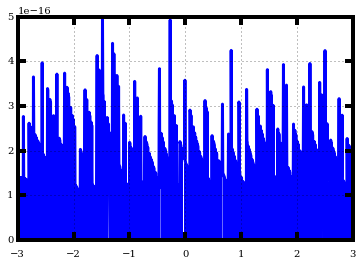

In [2]:
def fortran_phi(Md, Ma, rv, a):
    mfac1 = (Md + Ma)/Md
    mfac2 = ((Md + Ma)**2 + 3.0*Ma*(Md + Ma) + 9.0*Ma**2) / Md**2
    rfac = rv/a
    return -Md/rv*(1. + mfac1*rfac**3/3. + 4.*mfac2*rfac**6/45.)

#Making sure my version of Arras's phi expression agrees with the expression from the Fortran code
Ma = 1.
Md = 10.**np.linspace(-3., 3., 1000)
q = Md/Ma

a = 1.
r = 0.1

phiA = -Arras_phi(r, q)
phiF = fortran_phi(Md, Ma, r, a)

plt.plot(np.log10(q), np.abs(np.abs(phiA) - np.abs(phiF))/np.abs(phiA))

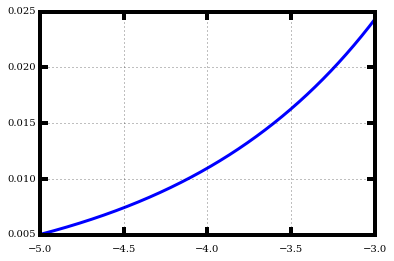

In [3]:
#Check calc_xL1
q = 10.**np.linspace(-5., -3., 1000)
xL1 = calc_xL1(q)

#Derivative is zero to a few parts in 1e9
#plt.plot(np.log10(q), np.abs(dpotroche_dr(xL1, q)))
plt.plot(np.log10(q), np.abs(xL1 - calc_smallq_roche_lobe(q))/xL1)

In [4]:
md = 1.0*cds.Mjup
rph = 1.0*cds.Rjup
ma = 1.0*cds.Msun
q = md.to('g').value/ma.to('g').value
a = 0.01*u.AU
rvL1 = eggletons_rvL1(q)*a
densityph = 5e-8*u.g/u.cm**3
Td = 2000.*u.K
vthermal = calc_vthermal(Td)
print(vthermal.to('km/s'))

print(Arras_fortran(md, ma, a, rph, densityph, Td).to('g/s'))
print(Mdot_Arras(md, ma, a, rph, densityph, vthermal).to('g/s'))

#  2016 Aug 30 -- Using my old version of the potentials, I get Mdot = -4833.01515752 g / s
#  within a factor of 2 of the value I get using Arras's potential, so not really different.

4.07785780665 km / s
-1.11766515875e+17 g / s
-3.61938513787e+20 g / s


In [5]:
rL1 = eggletons_rvL1(q)
xL1 = calc_xL1(q)
print(xL1, rL1)

potL1 = Arras_phi(rL1, q)
potph = Arras_phi(rph.to('km').value/a.to('km').value, q)
print(np.abs(potL1 - potph))

potph = potroche(rph.to('km').value/a.to('km').value, q)[0]
potL1 = potroche(xL1, q, theta=np.pi/2.)[0]
print(np.abs(potL1 - potph))

(0.066675228068277109, 0.047633748659029113)
5.54471257519e-05
0.00918962832103


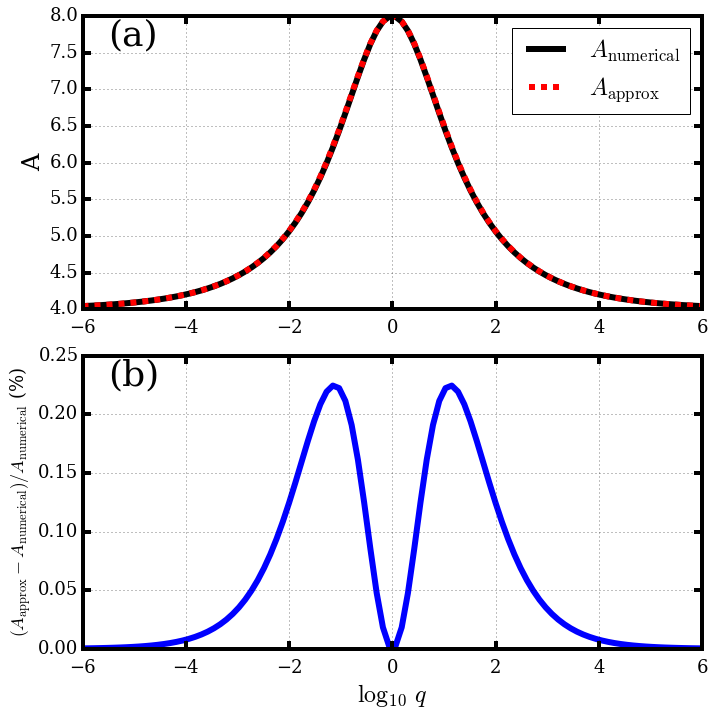

In [6]:
q_arr = 10.**(np.linspace(-6., 6., 100))

A_num_arr = np.array([])
A_approx_arr = A_approx(q_arr)
for q in q_arr:
    A_num_arr = np.append(A_num_arr, A_num(q))
    
fig = plt.figure(figsize=(10, 10))

ax = plt.subplot(211)
ax.tick_params(which='both', labelsize=18)

ax.set_ylabel('A', fontsize=24)
ax.plot(np.log10(q_arr), A_num_arr, lw=6, color='black', label='$A_{\\rm numerical}$')
ax.plot(np.log10(q_arr), A_approx_arr, lw=6, color='red', ls='--', label='$A_{\\rm approx}$')

ax.legend(fontsize=24)

ax.text(-5.5, 7.6, '(a)', fontsize=36)

#ax.get_xaxis().set_visible(False)

ax2 = plt.subplot(212)
ax2.plot(np.log10(q_arr), (A_approx_arr - A_num_arr)/A_num_arr*100., lw=6)
ax2.tick_params(which='both', labelsize=18)
ax2.text(-5.5, 0.225, '(b)', fontsize=36)

plt.ylabel('$\\left( A_{\\rm approx} - A_{\\rm numerical} \\right)/A_{\\rm numerical}$ (%)', fontsize=18)
plt.xlabel('$\\log_{\\rm 10}\ q$', fontsize=24)

fig.tight_layout() 
#plt.savefig('coeff_A.png', bbox_inches='tight', dpi=300)
#plt.savefig('coeff_A.eps', bbox_inches='tight', dpi=300) 

In [7]:
q = 1.
xL1 = calc_xL1(q)
potL1 = potroche(xL1, q)[0]

#Jupiter at a distance of 0.1 AU
Rp = 5e-4/0.1
potR = potroche(Rp, q, theta=0., phi=0.)[0]

print(Rp, find_r_pot(q, potR, 0., 0.))

#vol = calc_pot_vol(q, potR)

#phiL1 = 10**np.linspace(-3., -1., 100)

#print(phiL1)

(0.005, 0.005000000000000068)


(0.001, 0.00010836462322482172)
(0.01, 0.00040546585839297257)
(0.10000000000000001, 0.0012357514545375376)
(1.0, 0.0023311136345678385)
(10.0, 0.0047449725724380233)
(100.0, 0.013965066069571914)


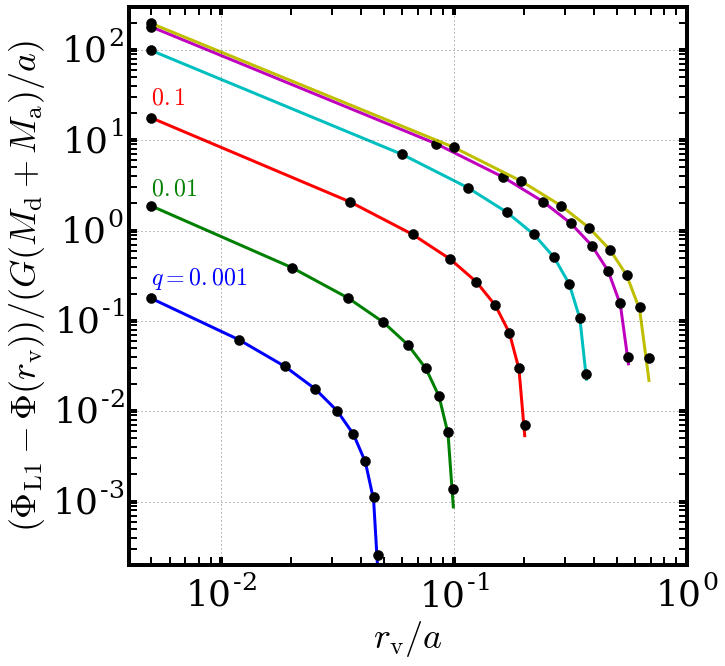

In [8]:
fig = plt.figure(figsize=(10,10))

colors = it.cycle(['b', 'g', 'r', 'c', 'm', 'y'])

q_arr = 10.**np.linspace(-3., 2., 6)

for q in q_arr:
    
    #Get the next line color
    cur_color = next(colors)
    
    xL1 = calc_xL1(q)
    potL1 = potroche(xL1, q)[0]
    
    r = np.linspace(Rp, calc_xL1(q), 10)
    
    pot = potroche(r, q)[0]
    rv = np.zeros_like(pot)
    for i in range(len(pot)):
        vol = calc_pot_vol(q, pot[i])
        rv[i] = calc_rv(vol)

    approx_pot = approx_pot_rv(rv, q)
    plt.loglog(rv, (potL1 - approx_pot)/(1. + q), lw=3, color=cur_color)
#    plt.axvline(eggletons_rvL1(q), color=cur_color, ls='--', lw=3)
    plt.loglog(rv, (potL1 - pot)/(1. + q), 'o', ms=10, color='black')
    
    print(q, np.max(np.abs(np.abs(approx_pot) - np.abs(pot))/np.abs(pot)))
    
plt.tick_params(which='both', labelsize=36)

plt.xlabel('$r_{\\rm v}/a$', fontsize=36)
plt.ylabel('$\\left( \\Phi_{\\rm L1} - \\Phi(r_{\\rm v}) \\right)/\\left( G(M_{\\rm d} + M_{\\rm a})/a \\right)$', fontsize=36)
plt.xlim([0.004, 1])
plt.ylim([2e-4, 300])

plt.text(0.005, 0.25, "$q = 0.001$", color='blue', fontsize=24)
plt.text(0.005, 2.5, "$0.01$", color='green', fontsize=24)
plt.text(0.005, 25., "$0.1$", color='red', fontsize=24)

#plt.savefig('potential_vs_volume_radius.png', bbox_inches='tight', dpi=300)
#plt.savefig('potential_vs_volume_radius.eps', bbox_inches='tight', dpi=300)

(1.0, 0.28255597476362504)
(0.017085831339264126, 0.013936276545525083)


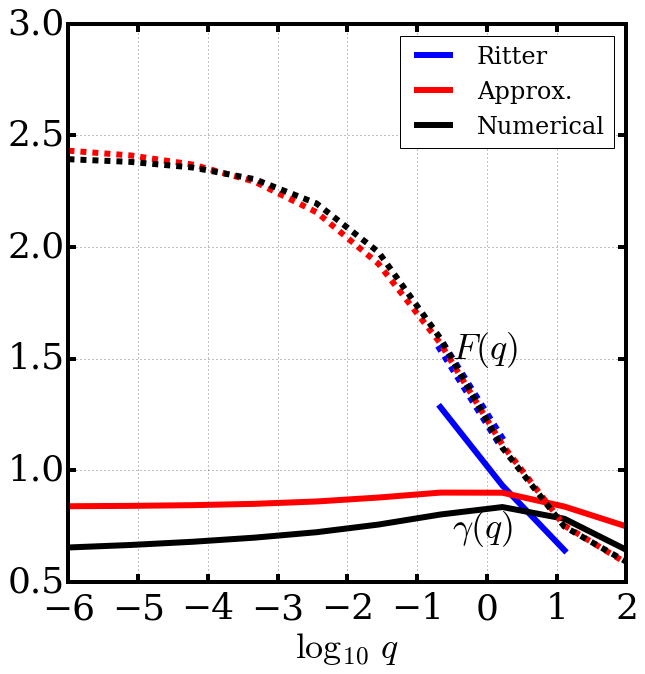

In [11]:
#The calculation really stalls when q gets big.
q_arr = 10**np.linspace(-6, 2, 10)

num_gamma = np.loadtxt("Jacksonetal_2015_RLO_figs_num-gamma.csv")

fig = plt.figure(figsize=(10,10))

colors = it.cycle(['blue', 'red', 'black'])

#gamma
gamma = ritters_gamma(q_arr)
plt.plot(np.log10(q_arr[gamma > 0]), gamma[gamma > 0], lw=6, label="Ritter", color=next(colors))
plt.plot(np.log10(q_arr), calc_approx_gamma(q_arr), lw=6, label="Approx.", color=next(colors))
plt.plot(np.log10(q_arr), num_gamma, lw=6, label="Numerical", color=next(colors))

#Only compare errors over range of q to which Ritter's formula applies
ind = np.nonzero(ritters_gamma)
print(np.nanmax(abs(ritters_gamma(q_arr[ind]) - num_gamma[ind])/num_gamma[ind]), 
      np.nanmax(abs(calc_approx_gamma(q_arr[ind]) - num_gamma[ind])/num_gamma[ind]))

#F(q)
bigF = ritters_bigF(q_arr)
plt.plot(np.log10(q_arr[bigF > 0]), bigF[bigF > 0], lw=12, ls='--', color=next(colors))
plt.plot(np.log10(q_arr), calc_approx_F(q_arr), lw=6, ls='--', color=next(colors))
num_F = np.array([calc_num_F(q) for q in q_arr])
plt.plot(np.log10(q_arr), num_F, lw=6, ls='--', color=next(colors))

#Only compare errors over range of q to which Ritter's formula applies
ind = np.nonzero(ritters_bigF(q_arr))
print(np.nanmax(abs(ritters_bigF(q_arr[ind]) - num_F[ind])/num_F[ind]), 
      np.nanmax(abs(calc_approx_F(q_arr[ind]) - num_F[ind])/num_F[ind]))

plt.legend(fontsize=24)
plt.tick_params(which='both', labelsize=36)
plt.xlabel('$\\log_{\\rm 10}\ q$', fontsize=36)
plt.ylim([0.5, 3])

plt.text(-0.5, 0.7, "$\\gamma(q)$", fontsize=36)
plt.text(-0.5, 1.5, "$F(q)$", fontsize=36)

#Have to use png format to keep transparency
#plt.savefig('compare_gamma-F.png', bbox_inches='tight', dpi=300)
#plt.savefig('compare_gamma-F.eps', bbox_inches='tight', dpi=300)

//anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:763: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



(1.0, 30.0)

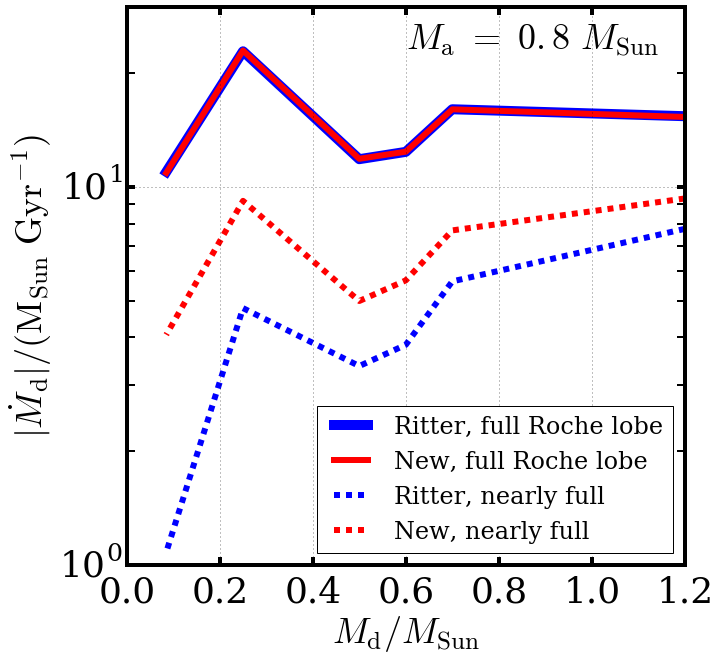

In [12]:
#md = 10.**(np.linspace(-1., 1., 1000))*u.solMass
#md = 1.2*u.solMass

#numbers from Ritter's appendix
Md = np.array([1.2, 0.7, 0.6, 0.5, 0.25, 0.085])*u.solMass
Rd = np.array([1.17, 0.67, 0.59, 0.52, 0.25, 0.1])*u.solRad
Td = np.array([6480., 4430., 3900., 3520., 3410., 2740.])*u.K
#molecular mass
mud = np.array([1.31, 1.31, 1.26, 1.33, 1.31, 1.33])*u.g/u.mol
amu = np.array([1.31, 1.31, 1.26, 1.33, 1.31, 1.33])*u.u

#Arras wants vthermal
densityph = np.array([0.25, 1.3, 1.4, 2.0, 16., 50.])*1e-6*(u.g/(u.cm)**3)

Ma = 0.8*u.solMass
q = (Md.to('kg')/Ma.to('kg')).value

Ta = 6000.*u.K
Ra = 1.*u.solRad

rvL1 = eggletons_rvL1(q)
potL1 = Arras_phi(rvL1, q)
#Put the donor at its Roche limit
a = Rd/rvL1

fig = plt.figure(figsize=(10,10))

colors = it.cycle(['blue', 'red'])

all_Mdot_Ritter = np.array([])
all_Mdot_Arras = np.array([])
for i in range(len(Md)):
    vthermal = calc_vthermal(Td[i], amu=amu[i])
    
    all_Mdot_Ritter = np.append(all_Mdot_Ritter, 
                                -Mdot_Ritter(Md[i], Ma, a[i], Rd[i], densityph[i], Td[i], 
                                             mu=mud[i]).to('solMass/year').value*1e9)
    all_Mdot_Arras = np.append(all_Mdot_Arras, 
                               -Mdot_Arras(Md[i], Ma, a[i], Rd[i], densityph[i],
                                           vthermal, delta_pot=(0.*u.J/u.kg)).to('solMass/year').value*1e9)
plt.semilogy(Md.to('solMass'), all_Mdot_Ritter, lw=10, color=next(colors), label="Ritter, full Roche lobe")
plt.semilogy(Md.to('solMass'), all_Mdot_Arras, lw=6, color=next(colors), label="New, full Roche lobe")

#Roche lobe 99% full
delta_r = 1e-4*rvL1*a
delta_pot = 1e-4*(-potL1)*const.G*Ma/a

all_Mdot_Ritter = np.array([])
all_Mdot_Arras = np.array([])
for i in range(len(Md)):
    vthermal = calc_vthermal(Td[i], amu=amu[i])
    all_Mdot_Ritter = np.append(all_Mdot_Ritter,
                                -Mdot_Ritter(Md[i], Ma, a[i], Rd[i], densityph[i], Td[i], mu=mud[i], 
                                             delta_r=delta_r[i]).to('solMass/year').value*1e9)
    all_Mdot_Arras = np.append(all_Mdot_Arras,
                               -Mdot_Arras(Md[i], Ma, a[i], Rd[i], densityph[i], vthermal, 
                                           delta_pot=delta_pot[i]).to('solMass/year').value*1e9)
plt.semilogy(Md.to('solMass'), all_Mdot_Ritter, lw=6, ls='--', color=next(colors), label="Ritter, nearly full")
plt.semilogy(Md.to('solMass'), all_Mdot_Arras, lw=6, ls='--', color=next(colors), label="New, nearly full")

plt.tick_params(which='both', labelsize=36)
plt.xlabel('$M_{\\rm d}/ M_{\\rm Sun}$', fontsize=36)
plt.ylabel('$|\dot{M}_{\\rm d}|/({\\rm M_{\\rm Sun}\ Gyr^{-1}})$', fontsize=36)

plt.legend(fontsize=24, loc='lower right')
plt.text(0.6, 23, "$M_{\\rm a}\ =\ 0.8\ M_{\\rm Sun}$", fontsize=36)

plt.ylim([1e0, 3e1])
# plt.text(0.7, 17, "Ritter's", color=next(colors), fontsize=36)
# plt.text(0.7, 9, "New model", color=next(colors), fontsize=36)

#plt.savefig('compare_mdot.png', bbox_inches='tight', dpi=300)
#plt.savefig('compare_mdot.eps', bbox_inches='tight', dpi=500)

In [13]:
def ret_pl_params(pl_dict, which_table='exoplanets', cand_or_conf=u'CANDIDATE'):

    cur_hostname, cur_pl_letter, cur_P, Mp, Rp, a, e, Ms, Rs, Ts, density, Tp, vthermal, rho_ph, Mdot = [None]*15

    #By default, don't calculate Mdot
    calc_Mdot = False
        
    density = 0.*u.g/u.cm**3
    
    if(which_table == 'exoplanets'):
    
        if((pl_dict['pl_bmassj'] is not None) &\
           (pl_dict['pl_radj'] is not None) &\
           (pl_dict['pl_orbsmax'] is not None) &\
           (pl_dict['pl_orbeccen'] < max_eccen) &\
           (pl_dict['st_mass'] is not None) &\
           (pl_dict['st_rad'] is not None) &\
           (pl_dict['st_teff'] is not None) &\
           (pl_dict['pl_orbper'] is not None) &\
           (pl_dict['pl_orbper'] < max_period)):
                
                cur_hostname = pl_dict['pl_hostname']
                cur_pl_letter = pl_dict['pl_letter']
                cur_P = pl_dict['pl_orbper']
                Mp = pl_dict['pl_bmassj']*cds.Mjup
                Rp = pl_dict['pl_radj']*cds.Rjup
                a = pl_dict['pl_orbsmax']*u.AU
                e = pl_dict['pl_orbeccen']
                Ms = pl_dict['st_mass']*u.solMass
                Rs = pl_dict['st_rad']*u.solRad
                Ts = pl_dict['st_teff']*u.K
                temp_dens = pl_dict['pl_dens']
                if(temp_dens != None): 
                    density = pl_dict['pl_dens']*u.g/u.cm**3
                
                Tp = calc_Teff(a.to('AU'), Rs.to('AU'), Ts)
                #Check that the planet's don't overfill Roche lobe
                if((3./2*Rp <= calc_xL1((Mp.to('kg')/Ms.to('kg')).value)*a) & 
                   ((Rp >= Rogers_Rp) & (Rp <= max_Rp))):
                    calc_Mdot = True
        
    elif(which_table == 'cumulative'):
        
        if((pl_dict['koi_period'] is not None) &\
           (pl_dict['koi_period'] < max_period) &\
           (pl_dict['koi_prad'] is not None) &\
           (pl_dict['koi_srad'] is not None) &\
           (pl_dict['koi_slogg'] is not None) &\
           (pl_dict['koi_teq'] is not None) &\
           (pl_dict['koi_disposition'] == cand_or_conf)):
            
            cur_hostname = pl_dict['kepoi_name']
            cur_pl_letter = None
            
            cur_P = pl_dict['koi_period']
            
            Rp = pl_dict['koi_prad']*cds.Rjup
            Tp = pl_dict['koi_teq']*u.K
                
            logg = pl_dict['koi_slogg']
            Rs = pl_dict['koi_srad']*u.solRad
            period = pl_dict['koi_period']*u.day
                
            Ms = ((10.**logg)*u.cm/u.s**2*Rs**2/const.G).to('solMass')
            a = ((const.G*Ms*(period/(2.*np.pi))**2.)**(1./3)).to('AU')

            #If Rp < 4 R_Earth, use Weiss & Marcy (2014) density
            temp_density = Weiss_density(Rp)
            if(temp_density != None):
                Mp = temp_density*4.*np.pi/3.*Rp**3
            elif(Rp > 4.*cds.Rgeo):
                Mp = 1.*cds.Mjup

            #Check that the planets don't overfill Roche lobe
                if((3./2*Rp <= calc_xL1((Mp.to('kg')/Ms.to('kg')).value)*a) & 
                   ((Rp >= Rogers_Rp) & (Rp <= max_Rp))):
                    calc_Mdot = True
                    
    if(calc_Mdot):
        vthermal = calc_vthermal(Tp)
        rho_ph = calc_photosphere_density(Mp, Rp, Tp)
        
        Mdot = Mdot_Arras(Mp, Ms, a, Rp, rho_ph, vthermal)

    return cur_hostname, cur_pl_letter, cur_P, Mp, Rp, a, e, Ms, Rs, Ts, density, Tp, vthermal, rho_ph, Mdot

In [14]:
#Mdot_Arras(Mp, Ms, a, Rp, rho_ph, vthermal)
pl_params_file = open("Jacksonetal_2016_RLO_pl_params_table_confirmed.csv", "w")

pl_dict = client.ea_request("exoplanets")
for i in range(len(pl_dict)):  

    cur_hostname, cur_pl_letter, cur_P, Mp, Rp, a, e, Ms, Rs, Ts, density, Tp, vthermal, rho_ph, Mdot = \
        ret_pl_params(pl_dict[i])

    if(Mdot is not None):
        if((-Mdot.to('g/s').value >= 1e9) & ((cur_P <= other_max_period) | (cur_hostname == "CoRoT-24"))):
            pl_params_file.write("%s %s, %s, %s, %.2f, %.0f, %s, %.5f, %.2f, %.2e, %.2e, %s" % 
                                 (cur_hostname, cur_pl_letter, Mp.value, Rp.value, 
                                  density.to('g/cm^3').value, Tp.to('K').value, 
                                  cur_P, a.to('AU').value, Ms.to('solMass').value, 
                                  -Mdot.to('g/s').value, -(Mdot.to('earthMass/year')*1e9).value,
                                "a"))
            pl_params_file.write("\n")
            
pl_params_file.close()

pl_params_file = open("Jacksonetal_2016_RLO_pl_params_table_candidate.csv", "w")
pl_dict = client.ea_request("cumulative")
for i in range(len(pl_dict)):  

    cur_hostname, cur_pl_letter, cur_P, Mp, Rp, a, e, Ms, Rs, Ts, density, Tp, vthermal, rho_ph, Mdot = \
        ret_pl_params(pl_dict[i], which_table = 'cumulative')

    if(Mdot is not None):
        if((-Mdot.to('g/s').value >= 1e9) & ((cur_P <= other_max_period) | (cur_hostname == "CoRoT-24"))):
            pl_params_file.write("%s, %s, %s, ..., %.0f, %s, %.5f, %.2f, %.2e, %.2e, %s" % 
                                 (cur_hostname, Mp.value, Rp.value, 
                                  Tp.to('K').value, cur_P, a.to('AU').value, Ms.to('solMass').value, 
                                  -Mdot.to('g/s').value, -(Mdot.to('earthMass/year')*1e9).value, 
                                "a"))
            pl_params_file.write("\n")
        
pl_params_file.close()

//anaconda/lib/python2.7/site-packages/astropy/units/quantity.py:777: FutureWarning:

comparison to `None` will result in an elementwise object comparison in the future.



In [15]:
#Add PTFO
hostname = 'PTFO8-8695'
Ms = 0.34*u.solMass
Rs = 1.04*u.solRad
Ts = 3470.*u.K
Qs = 1e7
Mp = 3.0*cds.Mjup
Rp = 1.64*cds.Rjup
q = Mp.to('kg').value/Ms.to('kg').value
P = 0.448410*u.day
a = Keplers_Third_Law(P=P, Mstar=Ms).to('AU')
Tp = calc_Teff(a, Rs, Ts)
scale_height = calc_scale_height(Mp, Rp, Tp)
xL1 = calc_smallq_roche_lobe(q)*a
rho_ph = calc_photosphere_density(Mp, Rp, Tp)
vthermal = calc_vthermal(Tp)

Mdot = Mdot_Arras(Mp, Ms, a, 2./3*xL1, rho_ph, vthermal)

pl_params_file = open("Jacksonetal_2016_RLO_pl_params_table_candidate.csv", "a")
pl_params_file.write("%s, %s, %s, ..., %.0f, %s, %.5f, %.2f, %.2e, %.2e, %s" % 
                     (hostname, Mp.to('Mjup').value, Rp.value, 
                      Tp.to('K').value, P.to('day').value, a.to('AU').value, Ms.to('solMass').value, 
                      -Mdot.to('g/s').value, -(Mdot.to('earthMass/year')*1e9).value,
                     "b"))
pl_params_file.write("\n")        
pl_params_file.close()

(<Quantity 1.47 jovMass>, <Quantity 1.9 Rjup>, <Quantity 1.43 solMass>, <Quantity 0.0234 AU>, <Quantity 3071.383811727065 K>)
(<Quantity 1.2052361058564088e-08 g / cm3>, <Quantity 5.053405231851674 km / s>)
3.20017515738e-13 g / cm3
2.72679224498e-14 g / cm3
1.33209673906e-10 g / cm3


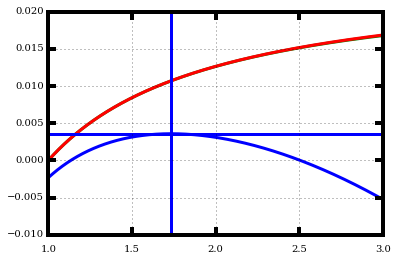

In [16]:
#Comparing my mass loss parameters to those from Li et al. (2010) for WASP-12 b
confirmed_planets = client.ea_request("exoplanets")
ind = 0
while((ind < len(confirmed_planets)) and (confirmed_planets[ind]['pl_hostname'] != 'WASP-12')):
    ind += 1
cur_P = confirmed_planets[ind]['pl_orbper']
Mp = confirmed_planets[ind]['pl_bmassj']*cds.Mjup
Rp = confirmed_planets[ind]['pl_radj']*cds.Rjup
a = confirmed_planets[ind]['pl_orbsmax']*u.AU
Ms = confirmed_planets[ind]['st_mass']*u.solMass
Rs = confirmed_planets[ind]['st_rad']*u.solRad
Ts = confirmed_planets[ind]['st_teff']*u.K
Tp = calc_Teff(a.to('AU'), Rs.to('AU'), Ts)
rph_over_a = (Rp.to('AU')/a.to('AU')).value

# Mp = 1.4*cds.Mjup
# Rp = 1.79*cds.Rjup
# Ms = 1.434*cds.Msun
# a = 0.0229*u.AU
# Tp = 3000.
print(Mp, Rp, Ms, a, Tp)

q = (Mp.to('kg')/Ms.to('kg')).value
xL1 = calc_xL1(q)

densityph = calc_photosphere_density(Mp, Rp, Tp)
vthermal = calc_vthermal(Tp)
print(densityph.to('g/cm^3'), vthermal.to('km/s'))
orb_freq = np.sqrt(calc_omegasq(q)*const.G*Ms/a**3)
exp = calc_exp(Mp, Ms, a, Rp, densityph, vthermal)
potph = potroche(rph_over_a, q)[0]*const.G*Ms/a

#Make sure to get the units right
potL1 = potroche(((2.1*cds.Rjup.to('AU'))/a.to('AU')).value, q, theta=np.pi/2.)[0]*const.G*Ms/a
delta_pot = potL1 - potph
densityRL = np.exp(-1./2)*densityph*np.exp(-(delta_pot.to('erg/g')/((vthermal.to('cm/s'))**2)))
print(densityRL.to('g/cm^3'))
#Gives densityRL = 4.42847407826e-15 g / cm3

potL1 = potroche(((3.2*cds.Rjup.to('AU'))/a.to('AU')).value, q)[0]*const.G*Ms/a
delta_pot = potL1 - potph
densityRL = np.exp(-1./2)*densityph*np.exp(-(delta_pot.to('erg/g')/((vthermal.to('cm/s'))**2)))
print(densityRL.to('g/cm^3'))
#Gives densityRL = 6.05517846967e-15 g / cm3

potL1 = potroche(((2.1*cds.Rjup.to('AU'))/a.to('AU')).value, q)[0]*const.G*Ms/a
delta_pot = potL1 - potph
densityRL = np.exp(-1./2)*densityph*np.exp(-(delta_pot.to('erg/g')/((vthermal.to('cm/s'))**2)))
print(densityRL.to('g/cm^3'))
#Gives densityRL = 1.64646855845e-11 g / cm3

area = nozzle_area(q, vthermal, orb_freq)

#Li's expression
lamb = const.G*Mp.to('kg')/Rp.to('m')/(5000.*u.m/u.s)**2.
#print(vthermal.to('m/s'))

# print(area.to('m^2'))
#print(densityph.to('g/cm^3'))
# print((q/3.)**(1./3)*a.to('km').value/(cds.Rjup.to('km')))
# print(Mp, Rp, a, Ms, Ts)
#print(xL1*(a.to('AU')/cds.Rjup.to('AU')).value)
#3.24046316671
#print(xL1*(a.to('AU')/Rp.to('AU')).value)
#1.81031461828

#print(delta_pot.to('erg/g'))
#print((const.G*Mp.to('kg')/Rp.to('m')*(1. - Rp/(2.1*cds.Rjup))).to('erg/g'))
    
# print((-(delta_pot.to('erg/g')/((500000.*u.cm/u.s)**2)).value))
# print((-(delta_pot.to('erg/g')/((vthermal.to('cm/s'))**2)).value))
# print((-lamb*(1. - Rp/(2.1*cds.Rjup))))
#-6.52426777262
#-9.36992449218
#-8.24409839221

#print((delta_pot.to('erg/g')/((500000.*u.cm/u.s)**2)).value)
#print((lamb*(1. - Rp/(2.1*cds.Rjup))))

#Comparing potential at L1 to potential 90 degrees away
#print(potroche(xL1, q, theta=0., phi=0.)[0])
#print(potroche((2.1*cds.Rjup.to('AU')/a.to('AU')).value, q, theta=np.pi/2., phi=0.)[0])
#print(potroche((2.1*cds.Rjup.to('AU')/a.to('AU')).value, q)[0])
#-1.52143841393
#-1.52505255885
#-1.52522121898

# print(-Mdot_Arras(Mp, Ms, a, Rp, densityph, vthermal).to('g/s').value)
# print(densityph, exp)

#Compare plots of potentials
radii = np.linspace(1, 3., 1000)
radii_over_a = radii*Rp.to('AU').value/a.to('AU').value
#Li's potential, divided through by G Mp/Rp
Li_pot = q/rph_over_a*(1. - 1./radii)
#my potential
potph = potroche(rph_over_a, q, theta=np.pi/2.)[0]
delta_pot = (potroche(radii_over_a, q)[0] - potph)
# plt.plot(radii, -delta_pot)
# plt.plot(radii, Li_pot, ls='--', lw=6)
#plt.plot(radii, np.abs(Li_pot - delta_pot)/np.abs(delta_pot))
#plt.ylim([-0.02, 0.02])
#plt.ylim([0, 5])
#plt.xlim([1., 2.])
#plt.axvline(xL1*(a.to('AU')/Rp.to('AU')).value)
#plt.axvline((2.1*cds.Rjup/Rp).value)

#So is YR really 2/3 XR? Where does that factor come from?
potL1 = potroche(xL1, q)[0]
#print(potL1, pot)
delta_pot = (potroche(radii_over_a, q)[0]) - potph
plt.plot(radii, delta_pot)
delta_pot = (potroche(radii_over_a, q, theta=np.pi/2.)[0]) - potph
plt.plot(radii, delta_pot)
plt.plot(radii, Li_pot)
plt.axhline(potL1 - potph)
plt.axvline(xL1*(a.to('AU')/Rp.to('AU')).value)
#plt.axvline(xL1*(a.to('AU')/Rp.to('AU')).value*2./3)

#AH-HA! I know what I'm doing wrong! The transit radius of the planet corresponds to potroche(Rp, q, theta=np.pi), 
#  NOT to potroche(Rp, q). Taking the latter value means that I'm OVERestimating delta pot between the photosphere
#  and xL1, which means I would UNDERestimate the density at xL1.

In [17]:
#Li et al.'s numbers
Mp = 1.4*cds.Mjup
Rp = 1.79*cds.Rjup
Ms = 1.434*cds.Msun
a = 0.0229*u.AU
Tp = 3000.

#2016 Nov 7 - EHHHHN! Li et al. were right. They were assuming atomic hydrogen when calculating the thermal velocity.
#  If I do the same, I get nearly the same answer - see below.
vthermal = calc_vthermal(3000*u.K)
print(vthermal.to('km/s'))

print("Here's the correct loss rate from Li+ (2010) using their model and numbers: %g" 
      % ((5e-8*u.g/u.cm**3)*np.exp(-59.*(1. - 1.79/2.1))*\
       np.pi*((0.22*3.2*cds.Rjup).to('cm'))**2.*500000.*u.cm/u.s).to('g/s').value)
print("Here's the loss rate reported in Li+ (2010): %g" % (1e-7*cds.Mjup/u.year).to('g/s').value)
print("Here's the loss rate from Arras's model using the numbers from Li+: %g" %\
     -Mdot_Arras(Mp, Ms, a, Rp, 5e-8*u.g/u.cm**3, 500000.*u.cm/u.s).to('g/s').value)

#2016 Oct 3 - Testing a difference velocity
print("Here's the loss rate from Arras's model using the correct thermal velocity: %g" %\
      -Mdot_Arras(Mp, Ms, a, Rp, 5e-8*u.g/u.cm**3, vthermal).to('g/s').value)
#Here's a check of my arithmetic using google -- http://tinyurl.com/jl8sens.

#2016 Nov 9 - Checking difference in potentials
print("Li's exp: ", np.exp(-59.*(1. - 1.79/2.1)))
print("Arras's exp: ", calc_exp(Mp, Ms, a, Rp, 5e-8*u.g/u.cm**3, vthermal))

4.99433543496 km / s
Here's the correct loss rate from Li+ (2010) using their model and numbers: 3.28286e+14
Here's the loss rate reported in Li+ (2010): 6.01662e+15
Here's the loss rate from Arras's model using the numbers from Li+: 2.93535e+14
Here's the loss rate from Arras's model using the correct thermal velocity: 2.87024e+14
("Li's exp: ", 0.00016500681043962859)
("Arras's exp: ", 7.405453391041949e-05)


('hot Jupiter: ', <Quantity 6.51887640154351e+17 (Unit not initialised)>, <Quantity 0.010500189434586749 AU>)
('hot Neptune: ', <Quantity 1.2187223684789131e+17 (Unit not initialised)>, <Quantity 0.009571539864495332 AU>)


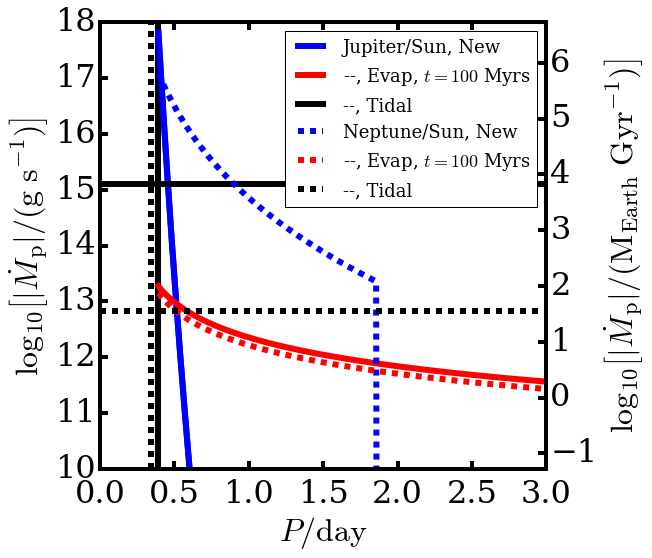

In [18]:
#Plot example
Mp = 1.*cds.Mjup
Rp = 1.*cds.Rjup
#GJ 1214
#Ms = 0.157*u.solMass
#Ts = 3030.*u.K

Ms = 1.*u.solMass
Rs = 1.*u.solRad
Ts = 6000.*u.K
Qs = 1e7

q = (Mp.to('kg')/Ms.to('kg')).value
a_Roche = (calc_smallq_roche_limit(q, Rp=3./2*Rp)).to('AU')
omegasq_Roche = calc_omegasq(Mp.to('kg')/Ms.to('kg'))*const.G*Ms/a_Roche**3
P_Roche = 2.*np.pi/np.sqrt(omegasq_Roche)
age = 1e8*u.year

#a = np.linspace(2.5*(Rs.to('AU').value), 10.*(Rs.to('AU').value), 1000)*u.AU
a = np.linspace((a_Roche.to('AU').value), 10.*(Rs.to('AU').value), 1000)*u.AU
Fxuv = Fx(age, a)
P = 2.*np.pi*np.sqrt(a**3/(const.G*Ms))

Tp = calc_Teff(a.to('AU'), Rs.to('AU'), Ts)
#Tp = np.full(len(a), 3000.)*u.K

#print(calc_exp(Mp, Ms, a, Rp, rho_ph, vthermal))
Mdot = np.array([])
for i in range(len(a)):
    vthermal = calc_vthermal(Tp[i])
    rho_ph = calc_photosphere_density(Mp, Rp, Tp[i])

    Mdot = np.append(Mdot, -Mdot_Arras(Mp, Ms, a[i], Rp, rho_ph, vthermal).to('g/s'))
#    Mdot = np.append(Mdot, -Mdot_Arras(Mp, Ms, a[i], Rp, rho_ph, vthermal).to('g/s'))

print("hot Jupiter: ", np.max(Mdot), np.min(a).to('AU'))
Mdot_tidal = dMpdt_tidal(Mp, Ms, Rs, a, Qs).to('g/s').value
Mdot_evap = dMpdt_evap(Mp, Ms, Rs, a, Rp, Fxuv).to('g/s').value

fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
    
ind = P.to('day') > P_Roche.to('day')
plt.plot(P.to('day')[ind], np.log10(Mdot)[ind], lw=6, color='blue', label='Jupiter/Sun, New')
#ax.text(1, np.log10(Mdot_tidal[0])*0.96, 'Tidal, $Q_\\star = 10^5$', fontsize=28, color='green')

plt.axvline(P_Roche.to('day').value, color='black', lw=6, zorder=-1)
#ax.text(0.1, 14, '$P_{\\rm Roche}$', rotation=90, fontsize=32)

#Make sure mass loss model plots on top
plt.plot(P.to('day')[ind], np.log10(Mdot)[ind], lw=6, color='blue')
#ax.text(0.5, 15, 'New', color='blue', fontsize=28)

plt.plot(P.to('day'), np.log10(Mdot_evap), lw=6, color='red', label='--, Evap, $t = 100$ Myrs')
plt.axhline(np.log10(np.max(Mdot_tidal)), lw=6, color='black', label='--, Tidal')
#ax.text(0.75, 11.5, 'Evap, $t = 1$ Gyrs', color='red', fontsize=28)

plt.tick_params(which='both', labelsize=32)
plt.xlabel('$P/{\\rm day}$', fontsize=32)
plt.ylabel('$\\log_{10}\\left[|\dot{M}_{\\rm p}|/({\\rm g\ s^{-1}})\\right]$', fontsize=32)
plt.grid(False)

Mp = 102.4e24*u.kg
Rp = 24622.*u.km
q = (Mp.to('kg')/Ms.to('kg')).value

a_Roche = (calc_smallq_roche_limit(q, Rp=3./2*Rp)).to('AU')
omegasq_Roche = calc_omegasq(Mp.to('kg')/Ms.to('kg'))*const.G*Ms/a_Roche**3
P_Roche = 2.*np.pi/np.sqrt(omegasq_Roche)
a = np.linspace((a_Roche.to('AU').value), 10.*(Rs.to('AU').value), 1000)*u.AU

#Tp.fill(1000.*u.K)
Mdot = np.array([])
for i in range(len(a)):
    vthermal = calc_vthermal(Tp[i])
    rp_over_a = (Rp.to('km')/a[i].to('km')).value
    rvph = Arras_rv(rp_over_a, q)
    rvL1 = eggletons_rvL1(q)
    del_pot = np.abs(Arras_phi(rvph, q) - Arras_phi(rvL1, q))*const.G*Ms/a[i]
#    print(P[i].to('day'), ((vthermal**2.).to('m^2/s^2')/(del_pot).to('m^2/s^2')).value)
    rho_ph = calc_photosphere_density(Mp, Rp, Tp[i])

    Mdot = np.append(Mdot, -Mdot_Arras(Mp, Ms, a[i], Rp, rho_ph, vthermal).to('g/s'))

#    Mdot = np.append(Mdot, -Mdot_Arras(Mp, Ms, a[i], Rp, rho_ph, vthermal).to('g/s'))

print("hot Neptune: ", np.max(Mdot), np.min(a).to('AU'))
Mdot_tidal = dMpdt_tidal(Mp, Ms, Rs, a, Qs).to('g/s').value
Mdot_evap = dMpdt_evap(Mp, Ms, Rs, a, Rp, Fxuv).to('g/s').value

#Make sure mass loss model plots on top
ind = P.to('day') > P_Roche.to('day')
plt.plot(P.to('day')[ind], np.log10(Mdot)[ind], lw=6, color='blue', ls='--', label='Neptune/Sun, New')
plt.plot(P.to('day'), np.log10(Mdot_evap), lw=6, color='red', ls='--', label='--, Evap, $t = 100$ Myrs')
plt.axhline(np.log10(np.max(Mdot_tidal)), lw=6, color='black', ls='--', label='--, Tidal')

plt.axvline(P_Roche.to('day').value, color='black', lw=6, ls='--', zorder=-1)

leg = plt.legend(loc='upper right', fontsize=18)

#2015 May 27 -- Label y-axis on the right, too
ax2 = ax.twinx()
g_per_s_to_Mearth_per_Gyr = (1e9*(1*u.year).to('second')/((1*cds.Mgeo).to('g'))).value

ax2.plot(P.to('day'), np.log10(Mdot), ls='')
ax2.tick_params(which='both', labelsize=32)
plt.ylabel('$\\log_{10}\\left[|\dot{M}_{\\rm p}|/({\\rm M_{\\rm Earth}\ Gyr^{-1}})\\right]$', fontsize=32)

ax.set_xlim(0, 3)
ax.set_ylim(10, 18)

ax2.set_ylim(np.log10(10**ax.get_ylim()[0]*g_per_s_to_Mearth_per_Gyr), 
             np.log10(10**ax.get_ylim()[1]*g_per_s_to_Mearth_per_Gyr))

plt.grid(False)

#plt.savefig('Mdot_map.png', bbox_inches='tight', dpi=300)
#plt.savefig('Mdot_map.eps', bbox_inches='tight', dpi=500)

#plt.savefig('Mdot_map_hot-scheme_with-tidal.png', bbox_inches='tight', dpi=300)
#plt.savefig('Mdot_map_orig-scheme_with-tidal.png', bbox_inches='tight', dpi=300)

1.24049609367 g / cm3


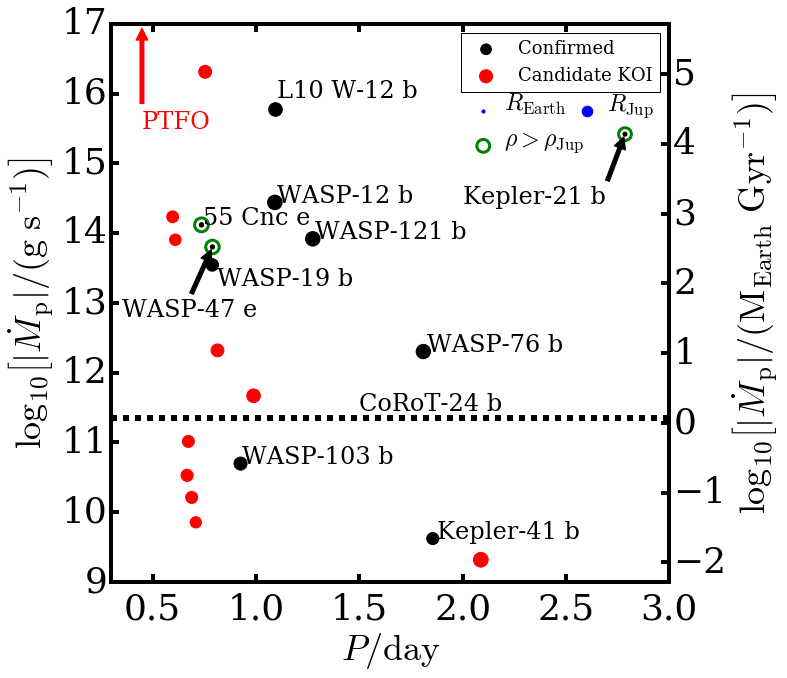

In [20]:
my_data = np.genfromtxt('Jacksonetal_2016_RLO_pl_params_table_confirmed.csv', delimiter=',', dtype=None, unpack=True)
#Unpack doesn't work, so have to iterate through array
confirmed_hostnames = list()
confirmed_P = np.array([])
confirmed_Rp = np.array([])
confirmed_Mdot = np.array([])
confirmed_density = np.array([])
for i in range(len(my_data)):
    confirmed_hostnames.append(my_data[i][0])
    confirmed_Rp = np.append(confirmed_Rp, float(my_data[i][2]))
    confirmed_density = np.append(confirmed_density, float(my_data[i][3]))
    confirmed_P = np.append(confirmed_P, float(my_data[i][5]))
    confirmed_Mdot = np.append(confirmed_Mdot, float(my_data[i][8]))

my_data = np.genfromtxt('Jacksonetal_2016_RLO_pl_params_table_candidate.csv', delimiter=',', dtype=None, unpack=True)
#Unpack doesn't work, so have to iterate through array
candidate_hostnames = list()
candidate_P = np.array([])
candidate_Rp = np.array([])
candidate_Mdot = np.array([])
candidate_density = np.array([])
for i in range(len(my_data)):
    candidate_hostnames.append(my_data[i][0])
    candidate_Rp = np.append(candidate_Rp, float(my_data[i][2]))
    candidate_P = np.append(candidate_P, float(my_data[i][5]))
    candidate_Mdot = np.append(candidate_Mdot, float(my_data[i][8]))

Jupiter_to_Earth_radii = ((1.*cds.Rjup.to('km'))/(1.*cds.Rgeo.to('km')))
    
ms_exp = 10
    
fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

p1 = ax.scatter(confirmed_P, np.log10(confirmed_Mdot), marker='o', s = ms_exp*confirmed_Rp*Jupiter_to_Earth_radii, 
                color='black', label='Confirmed')

p2 = ax.scatter(candidate_P, np.log10(candidate_Mdot), marker='o', s = ms_exp*candidate_Rp*Jupiter_to_Earth_radii, 
                color='red', label='Candidate KOI', zorder=-1)

#Indicate which planets have high density
Jupiters_density = cds.Mjup/(4.*np.pi/3.*(cds.Rjup)**3)
print(Jupiters_density.to('g/cm^3'))
ind = confirmed_density > (Jupiters_density.to('g/cm^3').value)
ax.scatter(confirmed_P[ind], np.log10(confirmed_Mdot[ind]), marker='o', 
           s = 10.*ms_exp*confirmed_Rp[ind]*Jupiter_to_Earth_radii, color='green', facecolors='none', linewidth=3)

plt.grid(False)
ax.set_xlim(0.3, 3)
ax.set_ylim(9, 17)

########################################
#Label especially interesting cases
########################################

corot24_ind = confirmed_hostnames.index('CoRoT-24 b')
plt.axhline(np.log10(confirmed_Mdot[corot24_ind]), color='black', lw=6, ls='--')
ax.text(1.5, np.log10(confirmed_Mdot[corot24_ind])*1.01, 'CoRoT-24 b', fontsize=24)

wasp12_ind = confirmed_hostnames.index('WASP-12 b')
ax.text(confirmed_P[wasp12_ind]*1.01, np.log10(confirmed_Mdot[wasp12_ind]*1.01), "WASP-12 b", fontsize=24)
Li_wasp12_mdot = (1e-7*cds.Mjup/u.year).to('g/s').value
p3 = ax.scatter(confirmed_P[wasp12_ind], np.log10(Li_wasp12_mdot), 
                s = ms_exp*candidate_Rp[wasp12_ind]*Jupiter_to_Earth_radii, marker='o', color='black')
ax.annotate("L10 W-12 b", xy=(confirmed_P[wasp12_ind]*1.01, 
                                     np.log10(Li_wasp12_mdot)*1.01),\
             xytext=(confirmed_P[wasp12_ind]*1.01, np.log10(Li_wasp12_mdot)*1.01), 
            fontsize=24, color='black')

Cnc55_ind = confirmed_hostnames.index('55 Cnc e')
ax.annotate("55 Cnc e", xy=(confirmed_P[Cnc55_ind]*1.01, 
                                     np.log10(confirmed_Mdot[Cnc55_ind]*1.01)),\
             xytext=(confirmed_P[Cnc55_ind]*1.01, np.log10(confirmed_Mdot[Cnc55_ind]*1.01)), 
            fontsize=24, color='black')

WASP121_ind = confirmed_hostnames.index('WASP-121 b')
ax.annotate("WASP-121 b", xy=(confirmed_P[WASP121_ind]*1.01, 
                                     np.log10(confirmed_Mdot[WASP121_ind]*1.01)),\
             xytext=(confirmed_P[WASP121_ind]*1.01, np.log10(confirmed_Mdot[WASP121_ind]*1.01)), 
            fontsize=24, color='black')

WASP19_ind = confirmed_hostnames.index('WASP-19 b')
ax.annotate("WASP-19 b", xy=(confirmed_P[WASP19_ind]*1.01, 
                                     np.log10(confirmed_Mdot[WASP19_ind]*1.01)),\
             xytext=(confirmed_P[WASP19_ind]*1.03, np.log10(confirmed_Mdot[WASP19_ind]*0.5)), 
            fontsize=24, color='black')

WASP76_ind = confirmed_hostnames.index('WASP-76 b')
ax.annotate("WASP-76 b", xy=(confirmed_P[WASP76_ind]*1.01, 
                                     np.log10(confirmed_Mdot[WASP76_ind]*1.01)),\
             xytext=(confirmed_P[WASP76_ind]*1.01, np.log10(confirmed_Mdot[WASP76_ind]*1.01)), 
            fontsize=24, color='black')

WASP103_ind = confirmed_hostnames.index('WASP-103 b')
ax.annotate("WASP-103 b", xy=(confirmed_P[WASP103_ind]*1.01, 
                                     np.log10(confirmed_Mdot[WASP103_ind]*1.01)),\
             xytext=(confirmed_P[WASP103_ind]*1.01, np.log10(confirmed_Mdot[WASP103_ind]*1.01)), 
            fontsize=24, color='black')

Kepler41_ind = confirmed_hostnames.index('Kepler-41 b')
ax.annotate("Kepler-41 b", xy=(confirmed_P[Kepler41_ind]*1.01, 
                                     np.log10(confirmed_Mdot[Kepler41_ind]*1.01)),\
             xytext=(confirmed_P[Kepler41_ind]*1.01, np.log10(confirmed_Mdot[Kepler41_ind]*1.01)), 
            fontsize=24, color='black')

Kepler21_ind = confirmed_hostnames.index('Kepler-21 b')
ax.annotate('Kepler-21 b', xy=(confirmed_P[Kepler21_ind], np.log10(confirmed_Mdot[Kepler21_ind])), color='black',
            xytext=(2., np.log10(confirmed_Mdot[Kepler21_ind])-1.), 
            arrowprops=dict(facecolor='black', edgecolor='black', shrink=0.05), fontsize=24)

WASP47e_ind = confirmed_hostnames.index('WASP-47 e')
ax.annotate('WASP-47 e', xy=(confirmed_P[WASP47e_ind], np.log10(confirmed_Mdot[WASP47e_ind])), color='black',
            xytext=(0.35, np.log10(confirmed_Mdot[WASP47e_ind])-1.), 
            arrowprops=dict(facecolor='black', edgecolor='black', shrink=0.05), fontsize=24)

PTFO_ind = candidate_hostnames.index('PTFO8-8695')
ax.annotate('PTFO', xy=(candidate_P[PTFO_ind], ax.get_ylim()[1]), color='red',
            xytext=(candidate_P[PTFO_ind], ax.get_ylim()[1]-1.5), 
            arrowprops=dict(facecolor='red', edgecolor='red', shrink=0.05), fontsize=24)

########################################
#Done labeling especially interesting cases
########################################

log10_Mjup_per_Gyr = np.log10(((1.*cds.Mjup)/(1e9*u.year)).to('g/s').value)

log10_Mearth_per_Gyr = np.log10(((1.*cds.Mgeo)/(1e9*u.year)).to('g/s').value)

ax.tick_params(which='both', labelsize=36)
plt.xlabel('$P/{\\rm day}$', fontsize=36)
plt.ylabel('$\\log_{10}\\left[|\dot{M}_{\\rm p}|/({\\rm g\ s^{-1}})\\right]$', fontsize=36)

#Add REarth to legend
REarth = ax.scatter(2.1, 15.75, s = ms_exp, color='blue')
ax.text(2.2, 15.75, "$R_{\\rm Earth}$", fontsize=24, color='black')
RJup = ax.scatter(2.6, 15.75, s = ms_exp*((cds.Rjup.to('km')/cds.Rgeo.to('km'))), color='blue')
ax.text(2.7, 15.75, "$R_{\\rm Jup}$", fontsize=24, color='black')

ax.scatter(2.1, 15.25, marker='o', s = 10.*ms_exp*confirmed_Rp[ind]*Jupiter_to_Earth_radii, color='green', 
           facecolors='none', linewidth=3)
ax.text(2.2, 15.25, "$\\rho > \\rho_{\\rm Jup} $", fontsize=24, color='black')

ax.legend(loc='best', scatterpoints=1, fontsize=18)

#handles, labels = ax.get_legend_handles_labels()
#ax.legend([p1, p2, REarth, RJup], [labels[0], labels[1], "$R_{\\rm Earth}$", "$R_{\\rm Jup}$"], scatterpoints=1, fontsize=18)

#2015 May 27 -- Label y-axis on the right, too
ax2 = ax.twinx()
g_per_s_to_Mearth_per_Gyr = (1e9*(1*u.year).to('second')/((1*cds.Mgeo).to('g'))).value

ax2.scatter(confirmed_P, np.log10(confirmed_Mdot*g_per_s_to_Mearth_per_Gyr), marker=None)
ax2.tick_params(which='both', labelsize=36)
plt.ylabel('$\\log_{10}\\left[|\dot{M}_{\\rm p}|/({\\rm M_{\\rm Earth}\ Gyr^{-1}})\\right]$', fontsize=36)

#2016 Jun 10 -- Add PTFO8-8695 using parameters reported in 
#  Barnes+ (2015 -- http://adsabs.harvard.edu/abs/2013ApJ...774...53B)
Ms = 0.34*u.solMass
Rs = 1.04*u.solRad
Ts = 3470.*u.K
Qs = 1e7
Mp = 3.0*cds.Mjup
Rp = 1.64*cds.Rjup
q = Mp.to('kg').value/Ms.to('kg').value
P = 0.448410*u.day
a = Keplers_Third_Law(P=P, Mstar=Ms).to('AU')
Tp = calc_Teff(a, Rs, Ts)
scale_height = calc_scale_height(Mp, Rp, Tp)
xL1 = calc_smallq_roche_lobe(q)*a
rho_ph = calc_photosphere_density(Mp, Rp, Tp)
vthermal = calc_vthermal(Tp)

Mdot_PTFO_tidal = dMpdt_tidal(Mp, Ms, Rs, a, Qs).to('g/s')
#print(Mdot_PTFO_tidal)

#Have to set twice
ax.set_xlim(0.3, 3)
ax.set_ylim(9, 17)

ax2.set_ylim(np.log10(10**ax.get_ylim()[0]*g_per_s_to_Mearth_per_Gyr), 
             np.log10(10**ax.get_ylim()[1]*g_per_s_to_Mearth_per_Gyr))

plt.grid(False)

#plt.savefig('Mdots_real.png', bbox_inches='tight', dpi=300)
#plt.savefig('Mdots_real.eps', bbox_inches='tight', dpi=500)

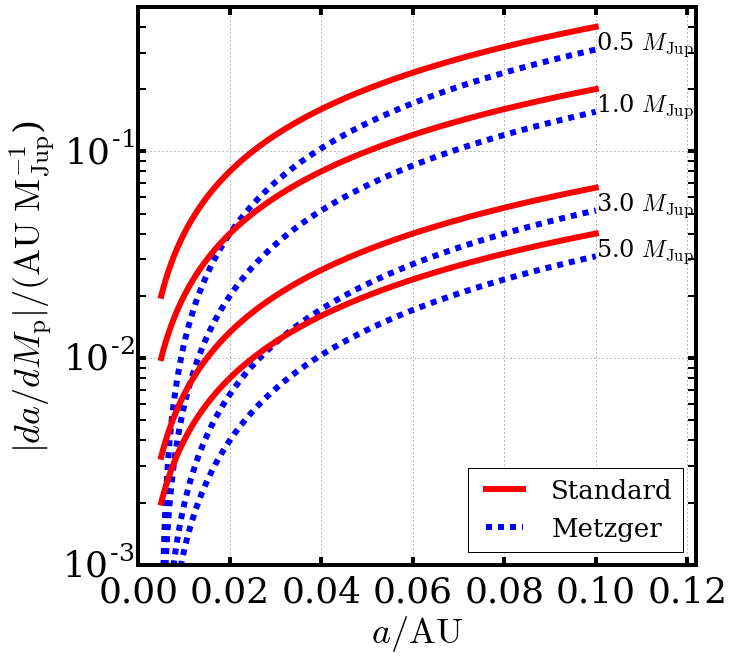

In [24]:
#2014 Oct 28 -- Plots da/dMp vs. a for a range of planetary masses

MJup_to_MSun = 1.
RSun_to_AU = 5e-3

Mp_arr = [0.5, 1., 3., 5.]
a_arr = np.linspace(RSun_to_AU, 20.*RSun_to_AU, num=1001)

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

for cur_Mp in Mp_arr:

  #Here's the classic expression
  dadMp_classic = 2.*a_arr[:]/cur_Mp

  #Metzger's expression
  dadMp_Metzger = 2.*a_arr[:]/cur_Mp*(1. - np.sqrt(RSun_to_AU/a_arr[:]))
  p1 = ax.plot(a_arr, dadMp_classic, color='red', lw=6, label='Classic')
  p2 = ax.plot(a_arr, dadMp_Metzger, color='blue', ls='--', lw=6, label='Metzger')

  ax.text(a_arr[-1], dadMp_Metzger[-1], str(cur_Mp) + " $M_\mathrm{Jup}$", fontsize=24)

ax.set_yscale('log')

plt.xlim(0, 0.122)
plt.ylim(1e-3, 5e-1)
plt.xlabel('$a/{\\rm AU}$', fontsize=36)
plt.ylabel('$|da/dM_\mathrm{p}|/({\\rm AU\ M_\mathrm{Jup}^{-1}}$)', fontsize=36)

plt.tick_params(which='both', labelsize=36)

handles, labels = ax.get_legend_handles_labels()

plt.legend([handles[0], handles[1]], ['Standard', 'Metzger'], fontsize=26, loc='lower right')

#plt.savefig('dadMp_vs_a.png', bbox_inches='tight', dpi=300)
#plt.savefig('dadMp_vs_a.eps', bbox_inches='tight', dpi=500)

2015 Aug 3 -- Calculations and figures in response to the referee report

In [26]:
#Attempting to reproduce the loss rate presented in Murray-Clay+ (2009), Figure 1, given as 3.3e10 g/s
Rp = 4.327*cds.Rgeo
Mp = 22.2*cds.Mgeo
Ms = 0.41*u.solMass
Ts = 3318.*u.K #from wikipedia page of HD 209458
a = 0.0291*u.AU

print((cds.G*Mp.to('kg')/Rp.to('m')**2).to('m/s^2'))

#Tp = calc_Teff(a.to('AU'), Rs.to('AU'), Ts)*10.
Tp = 3000.*u.K
H = calc_scale_height(Mp, Rp, Tp)
vthermal = calc_vthermal(Tp, amu=1.*u.u)
#rho_ph = calc_photosphere_density(Mp, Rp, Tp)
#rho_ph = 5.1e-15*u.g/(u.cm)**3
#rho_ph = 1e8*1.66e-24*u.g/(u.cm)**3
#print(H.to('km'), rho_ph.to('g/cm^3')*H.to('cm')*1e-2*u.cm**2/u.g/0.56)

#Fiducial column density by which point Lyman continuum from star becomes optically thick
N = 1e18/u.cm**2 #cm^{-2}
rho_ph = N/H*1.*u.u
print(rho_ph.to('g/cm^3'))

print(np.log10(-Mdot_Arras(Mp, Ms, a, Rp, rho_ph, vthermal).to('g/s').value))

11.6210984754 m / s2
7.73643401306e-15 g / cm3
7.99937499811


2016 Jun 8 -- Trying to apply Ritter (1988) expressions to understand the timescale for mass loss instability.

Ritter's (1988) Eqn 15:

$\tau_{\rm \dot{M}_2} = \dfrac{\dot{M}_2}{\ddot{M}_2} = \dfrac{H_{\rm p}}{R_{\rm 2}} \left\{ \dfrac{\dot{M}_2}{M_2} \left( \zeta_{\rm 2, s} - \zeta_{\rm {R, 2}} \right) + \dfrac{1}{\tau_{\rm R_2}} - \dfrac{2}{\tau_{\rm J}} \right\}^{-1}, $

where $\zeta_{\rm 2, s} \equiv \left(\dfrac{\partial \ln R_2}{\partial \ln M_2} \right)_{\rm S} \approx 0$ for hot Jupiters, <br> 

$\zeta_{\rm 2, R} \equiv \dfrac{\partial \ln R_{\rm 2, R}}{\partial \ln M_2} \approx -1/3$ for $q \ll 1$, <br>

$\tau_{\rm R_2} \equiv \left(\dfrac{\partial \ln R_2}{\partial \ln M_2}\right)_{\rm M_2} \sim$ 10 Gyr for hot Jupiters, <br>

$\tau_{\rm J} \equiv \dfrac{J}{\dot{J}} \sim$ 10 Myrs for a hot Jupiter near its Roche limit.

Plugging everything in gives <br>
$\tau_{\rm \dot{M}_2} = \left( \dfrac{\rm 1000\ km}{\rm 70000\ km} \right) \left\{ \dfrac{10^{18}\ {\rm g\ s^{-1}}}{2\times10^{30}\ {\rm g}} \left(0 - \frac{1}{3} \right) + \dfrac{1}{\rm 10\ Gyr} - \dfrac{1}{1\ {\rm Gyr}}\right\}^{-1} \sim 3000\ {\rm yr}$.

http://tinyurl.com/j8z4nn8

What about for hot Neptunes? There, $M_2 = 17\ {\rm M_{Earth}} = 10^{29}\ {\rm g}$, $R_2 = 4\ {\rm R_{Earth}}$, $H_{\rm p} = k\ ({\rm 3000\ K})/\left[ \mu\ (11.1\ {\rm m/s^2})\right] = 2000\ {\rm km}$.

$\tau_{\rm \dot{M}_2} = \left( \dfrac{\rm 2000\ km}{\rm 24000\ km} \right) \left\{ \dfrac{10^{17}\ {\rm g\ s^{-1}}}{10^{29}\ {\rm g}} \left(0 - \frac{1}{3} \right) + \dfrac{1}{\rm 10\ Gyr} - \dfrac{1}{10\ {\rm Gyr}}\right\}^{-1} \sim 8000\ {\rm yr}$

http://tinyurl.com/hnpf37y

From Pringle (1981 -- http://adsabs.harvard.edu/abs/1981ARA%26A..19..137P), the viscous timescale $\tau_{\rm visc} \sim R_{\rm 0}^2/\left(\alpha c_{\rm s} H\right)$, where $\alpha \sim 0.01$ (Chambers 2009), $R_{\rm 0} \sim 0.01\ {\rm AU}$, and $c_{\rm s} \approx 5\ {\rm km/s}$. <br>

Also, $H/R = c_{\rm s}/\Omega \approx \left( 5\ {\rm km/s}\right)\left( 1\ {\rm day} \right)/\left(2 \pi\times 0.01\ {\rm AU}\right) \approx 0.05$.

Thus, $\tau_{\rm visc} \sim \left(0.01\ {\rm AU}\right)/ \left(0.01\ \times 5\ {\rm km/s}\ \times 0.05\right) \approx 20\ {\rm years}$.